# Notebook 3

#### Imports

In [1]:
#General purpose
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
import time

#tokenizers, lemmatizers and vectorizers
import spacy
from spacy.tokenizer import Tokenizer

#model, metrics and cross val tools
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier

In [83]:
#reading in cleaned dataset from book 2
df = pd.read_csv('../Datasets/combined_cleaned.csv')

## Tokenization and Lemmatization with Spacy

In [84]:
# loading language module from spacy that we will use to tokenize and lemmatize
#python -m spacy download en_core_web_sm - might require download
nlp = spacy.load('en_core_web_sm')

In [85]:
# formating the titles to be all lowercase
df['title'] = [title.lower() for title in df['title']]

In [86]:
#using spacy to create a doc from the post titles
df['doc'] = [nlp(title) for title in df['title']]
#obtaining the tokens from the doc created by spacy
df['tokens'] = [[token.text for token in doc] for doc in df['doc']]

In [87]:
# creating a list of stopwords for use later
stopwords = []
for doc in df['doc']:
    for token in doc:
        if token.is_stop == True:
            if token.text not in stopwords:
                stopwords.append(str(token.text))

#adding 2 items additional strings into stop word list
stopwords.append('ve')
stopwords.append('ll')

In [88]:
#checking if looped worked as intended
stopwords[:5]

['to', 'using', 'his', 'has', 'off']

In [89]:
# storing the lemmatized version of tokens into a new row
df['lemmas'] = [[token.lemma_ for token in doc] for doc in df['doc']]

In [90]:
df.head()

,subreddit,title,title_length,title_word_count,language,doc,tokens,lemmas
0,TheOnion,man admits to using frozen poo-filled condom t...,61,11,en,"(man, admits, to, using, frozen, poo, -, fille...","[man, admits, to, using, frozen, poo, -, fille...","[man, admit, to, use, frozen, poo, -, fill, co..."
1,TheOnion,smooth recovery: exxonmobil has played off the...,102,18,en,"(smooth, recovery, :, exxonmobil, has, played,...","[smooth, recovery, :, exxonmobil, has, played,...","[smooth, recovery, :, exxonmobil, have, play, ..."
2,TheOnion,greatest country in world unable to keep willi...,76,13,en,"(greatest, country, in, world, unable, to, kee...","[greatest, country, in, world, unable, to, kee...","[great, country, in, world, unable, to, keep, ..."
3,TheOnion,nation not sure how many ex-trump staffers it ...,65,11,en,"(nation, not, sure, how, many, ex, -, trump, s...","[nation, not, sure, how, many, ex, -, trump, s...","[nation, not, sure, how, many, ex, -, trump, s..."
4,TheOnion,advisors instruct william barr to avoid referr...,100,15,en,"(advisors, instruct, william, barr, to, avoid,...","[advisors, instruct, william, barr, to, avoid,...","[advisor, instruct, william, barr, to, avoid, ..."


As mentioned in the previous code book a significant number of the words have the same root word by lemmatizing to the root word we can reduce the number of features which will reduce processing time while possibly also imporoving performance.

In [91]:
# compining all the lemmatized tokens into a single string under a new column
df['tok_lem_titles'] = [' '.join(sentence) for sentence in df['lemmas']]

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9300 entries, 0 to 9299
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subreddit         9300 non-null   object
 1   title             9300 non-null   object
 2   title_length      9300 non-null   int64 
 3   title_word_count  9300 non-null   int64 
 4   language          9300 non-null   object
 5   doc               9300 non-null   object
 6   tokens            9300 non-null   object
 7   lemmas            9300 non-null   object
 8   tok_lem_titles    9300 non-null   object
dtypes: int64(2), object(7)
memory usage: 654.0+ KB


In [93]:
# mapping numerical values to the subreddits
df['labels'] = df['subreddit'].map({'TheOnion': 1, 'nottheonion': 0})

In [94]:
df[df.duplicated(subset = 'tok_lem_titles')]['tok_lem_titles']

753     group of hunky cardinal appeal to pope to rela...
1051             situation in nigeria seem pretty complex
3507    increasingly worried man have not yet come acr...
4275    study find virus frequently fool by fake vacci...
4328                   way to apologize without say sorry
4692    hamas call on justin bieber to cancel show in ...
4862    national guard deploy to enforce vaccine manda...
4891    republicans ban elmo from attend conservative ...
4988    hamas call on justin bieber to cancel show in ...
5226    ivermectin may help covid-19 patient , but onl...
5336    apparent jilt ex spray paint " mike be a cheat...
5363    man who smuggle ' squid game ' into north kore...
5374    man who smuggle ' squid game ' into north kore...
5481    walmart pull child 's toy that swear and sing ...
5554    who skip greek letter ' xi ' to name new covid...
5599    big bird and sesame street friend ban from lar...
5614                      dogphone will let dog use phone
5785    walmar

After tokenizing and lemmatizing there are still some duplicates, this is likely because the of differences in formatting, casing or inclusion of emoji and typos we will drop the remaining duplicates.

In [95]:
df.drop_duplicates(subset = 'tok_lem_titles', keep = 'last', inplace = True)

In [96]:
df.groupby('subreddit').count()

,title,title_length,title_word_count,language,doc,tokens,lemmas,tok_lem_titles,labels
subreddit,,,,,,,,,
TheOnion,4644,4644,4644,4644,4644,4644,4644,4644,4644
nottheonion,4597,4597,4597,4597,4597,4597,4597,4597,4597


In [97]:
#splitting the dataset based on subreddit.
df_not = df[df.subreddit == "nottheonion"][['subreddit','tok_lem_titles','labels', 'doc']]
df_onion = df[df.subreddit == "TheOnion"][['subreddit','tok_lem_titles','labels', 'doc']]

In [98]:
df_not.reset_index(inplace = True, drop = True)
df_onion.reset_index(inplace = True, drop = True)

In [99]:
#creating a function that drops rows at random from onion until sample size of onion/notonion is the same
for i in range(0, (len(df_onion)-len(df_not))):
    number = random.randint(0, len(df_not))
    df_onion.drop(number, inplace = True)
    df_onion.reset_index(inplace = True, drop = True)

In [100]:
#combining the dataset into a single df
df = df_onion.append(df_not)
df.reset_index(inplace = True, drop = True)

In [101]:
df.groupby('subreddit').count()

,tok_lem_titles,labels,doc
subreddit,,,
TheOnion,4597,4597,4597
nottheonion,4597,4597,4597


In [102]:
#saving final dataset into a new csv
df.to_csv('../Datasets/combined_cleaned2.csv', index = False)

## Train Test Split

In [103]:
#setting features (X) and variable (y)
X = df['tok_lem_titles']
y = df['labels']

In [104]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [105]:
#creating function to plot confusion matrix and classification report
def basic_metrics(model):
    print(f'train accuracy score {round(model.score(X_train, y_train),2)}')
    print(f'test accuracy score {round(model.score(X_test, y_test),2)}')
    model_preds = model.predict(X_test)

    print(classification_report(y_test, model_preds, target_names = ['NotOnion', 'Onion']))

    cm = confusion_matrix(y_test, model_preds, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['not onion', 'onion'])
    disp.plot(cmap = 'Blues');

## Modeling

To build an nlp model we first have to take the words and convert them into numerical features that the model can process.

By using a vectorizer we can take our collection of post titles that we tokenized and lemmatized and convert each unique word into a vector. The vectorizer then assigns a value to each vector for each sample.

The value assigned is based on the vectorizer used. Count vectorizer assigns values based the frequency that a term appears in a given document, while tf-idf assigns values based on a score derived from the term frequency multiplied by the log total of the total number of the number of documents divided by the number of documents that contains the term.

For our models both vectorizers produced similar results, with countvectorizer producing a slight edge in performance.

#### Models used
For classification problems we have a variety of options to choose from. We will first compare the performance of the Logistic Regression Model, K-Nearest Neighbours, Multinomial Niave Bayes and Random Forest based on the default parameters before tuning the models for opitmal performance.

First we will build a baseline model that we can use to make comparisons against.

### Baseline Model
We'll use sklearn dummy classifier to set up a baseline to assess model performance. Since the sample size for each subreddit is the same we will set the strategy parameter to 'uniform'. Using this strategy the model will apply equal probability to each class and make random predictions. Expected accuracy should be ~50%.

In [106]:
#setting up dummy classifier pipe
pipe_dumb = Pipeline([
    ('cvec', CountVectorizer()),
    ('dummy', DummyClassifier(strategy="uniform"))
])


In [107]:
pipe_dumb.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()),
                ('dummy', DummyClassifier(strategy='uniform'))])

train accuracy score 0.49
test accuracy score 0.51
              precision    recall  f1-score   support

    NotOnion       0.49      0.49      0.49      1518
       Onion       0.49      0.50      0.50      1517

    accuracy                           0.49      3035
   macro avg       0.49      0.49      0.49      3035
weighted avg       0.49      0.49      0.49      3035



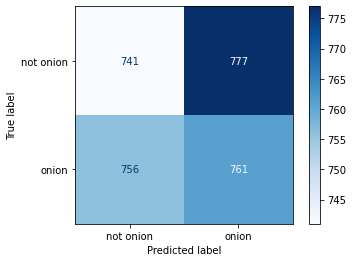

In [108]:
basic_metrics(pipe_dumb)

The dummy model selecting at random results in about 50% accuracy as expected.

### Multinomial Niave Bayaes
For our 1st model we will use NB as our classifier.

In [109]:
# creating a pipe that 1st vectorizes our data before fitting them on a model
pipe_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [110]:
#fitting the model
pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

train accuracy score 0.93
test accuracy score 0.81
              precision    recall  f1-score   support

    NotOnion       0.82      0.80      0.81      1518
       Onion       0.80      0.82      0.81      1517

    accuracy                           0.81      3035
   macro avg       0.81      0.81      0.81      3035
weighted avg       0.81      0.81      0.81      3035



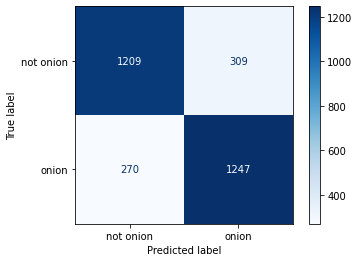

In [111]:
#obtaining metrics and CM for model
basic_metrics(pipe_nb)

Right away we see that our model performs significantly better than the baseline model. Our MNB model on the training data is able to correctly predict ~80% of samples on the test data.

Accuracy score of the model on the training data is notably better on the training data than the test data indicating a degree of overfitting.

## Logreg

In [112]:
pipe_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [113]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('lr', LogisticRegression())])

train accuracy score 0.98
test accuracy score 0.81
              precision    recall  f1-score   support

    NotOnion       0.81      0.81      0.81      1518
       Onion       0.81      0.81      0.81      1517

    accuracy                           0.81      3035
   macro avg       0.81      0.81      0.81      3035
weighted avg       0.81      0.81      0.81      3035



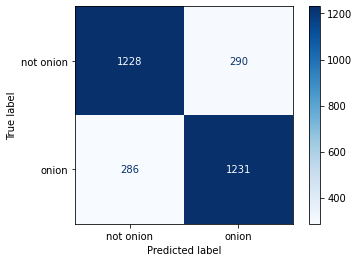

In [114]:
#obtaining metrics and CM for model
basic_metrics(pipe_lr)

Again we see that the model does notably better on the training data compared to the test data.

Log Regression performs similarly to our MNB model, performance for this model can also be hypertuned to optimize performance.

Based on the difference between the training and test scores there the model seems more overfitted than the previous MNB model

### KNN Model

In [115]:
pipe_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('KNN', KNeighborsClassifier())
])

In [116]:
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('KNN', KNeighborsClassifier())])

train accuracy score 0.74
test accuracy score 0.59
              precision    recall  f1-score   support

    NotOnion       0.57      0.72      0.64      1518
       Onion       0.63      0.46      0.53      1517

    accuracy                           0.59      3035
   macro avg       0.60      0.59      0.59      3035
weighted avg       0.60      0.59      0.59      3035



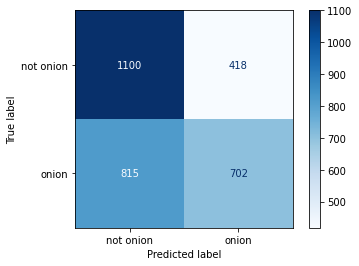

In [117]:
#obtaining accuracy score for model
basic_metrics(pipe_knn)

The KNN model barely performs better than our baseline mode.

Hypertuning the model is not expected to increase prediction accuracy or f1 score enough to surpass the two previous models. Considering that the number of features might increase when hypertuning (since we are also introducing parameters like n_grams), tuning the model is likely to take a considerable amount of time while yielding weaker performance than our other models.

In addition, as feature importance is not possible with KNN. Model interpretability might be an issue when utilising the KNN model.

Considering this we will not consider KNN for further evaluation.

### Decision Trees

In [118]:
pipe_dt = Pipeline([
    ('cvec', CountVectorizer()),
    ('dt', DecisionTreeClassifier())
])

In [119]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('dt', DecisionTreeClassifier())])

train accuracy score 1.0
test accuracy score 0.7
              precision    recall  f1-score   support

    NotOnion       0.71      0.68      0.70      1518
       Onion       0.70      0.73      0.71      1517

    accuracy                           0.70      3035
   macro avg       0.71      0.70      0.70      3035
weighted avg       0.71      0.70      0.70      3035



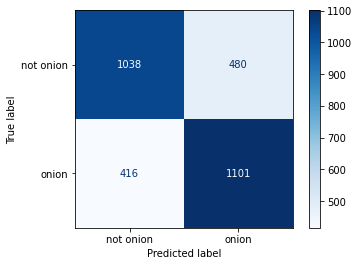

In [120]:
#obtaining accuracy score for model
basic_metrics(pipe_dt)

Model performance for decision trees is better than the KNN model but notably worse than the LR and MNB models.

In our modelling process we are also experimenting with the Random forest classifier which makes classifications by randomly generating a large number of decision tress and combining the outputs of those trees to make a final classification. Considering that random forest classifier has a lower risk of overfitting and is expected to perform well on our relatively large dataset, we will also drop DT from further evaluation.

### Random Forest

In [121]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [122]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('rf', RandomForestClassifier())])

train accuracy score 1.0
test accuracy score 0.77
              precision    recall  f1-score   support

    NotOnion       0.80      0.73      0.76      1518
       Onion       0.75      0.82      0.78      1517

    accuracy                           0.77      3035
   macro avg       0.78      0.77      0.77      3035
weighted avg       0.78      0.77      0.77      3035



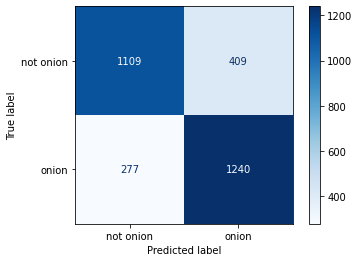

In [123]:
#obtaining accuracy score for model
basic_metrics(pipe_rf)

### SVM

In [124]:
pipe_svc = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())
])

In [125]:
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('svc', SVC())])

train accuracy score 0.97
test accuracy score 0.8
              precision    recall  f1-score   support

    NotOnion       0.82      0.78      0.80      1518
       Onion       0.79      0.83      0.81      1517

    accuracy                           0.80      3035
   macro avg       0.80      0.80      0.80      3035
weighted avg       0.80      0.80      0.80      3035



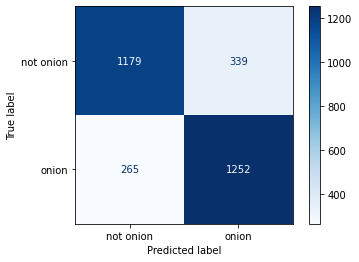

In [126]:
basic_metrics(pipe_svc)

SVM produces results that are similar to our other better performing models. SVM tends to be slow on large datasets and since we already have 3 models that perform well (LR, MNB and RF) we will also drop svm from consideration.

## Hyperparameter Tuning

The goal for our project is to develop a model that can correctly classify  real and fake news. As such the consequences of false positives and false negatives are equally severe.

A suitable metric for our model would have to provide a balance between precision and recall. F1 score would works well for our purposes as it can tell us how precise and robust our model in a single metric.

Hyperparameter tuning is the process of iterating through various combinination of hyperparamets within our model to determine the best combination that maximises our chosen metric.

By using gridsearchcv we can tune both the parameters for our vectorizer and the various models to achieve the best f1 score.

In [129]:
#creating a function that creates a gridsearch
def metrics_func(model):

    #model scoring
    print(f'Best f1 score for model is {model.best_score_}')
    print(f'test f1 score {round(model.score(X_test, y_test),2)}')
    print(f'Best params is {model.best_params_}')

    #confusion matrix
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['not onion', 'onion'])
    disp.plot(cmap = 'Blues');

    # classification report
    print(classification_report(y_test, preds, target_names = ['NotOnion', 'Onion']))

def roc_plot(model, model_name):
    #fpr, tpr, predicted proba for AUC plot
    pred_proba = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, pred_proba[:,1])
    roc_auc = auc(fpr, tpr)
    #AUC plotting
    plt.title('Receiver Operating Characteristic for' +model_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


### Tuning for MNB

In [130]:
## Parameters to tune for nb model
nb_params = {
    'nb__alpha': [i for i in np.linspace(0.3, 0.7, 3)],
    'nb__fit_prior': [True, False]
}
# Parameters to tune cvec
cvec_params = {
    'cvec__max_features': [5_000, 7000, None],
    'cvec__min_df': [i for i in range(1, 3, 1)],
    'cvec__max_df': [i for i in np.linspace(0.3, 0.8, 5)],
    'cvec__ngram_range': [(1,i) for i in range (1,5)],
    'cvec__stop_words':[None, stopwords]#EDA revealed that there are significant number of stopwords in the dataset and our list of stopwords can help reduce the number of features and improve performance
}

In [131]:
#combining the countvectorizer parameters and mnb params into a single dictionary
nb_params = nb_params|cvec_params

In [132]:
gs_nb = GridSearchCV(pipe_nb,
                     param_grid=nb_params,
                     cv=5,
                     n_jobs=-1,
                     scoring = 'f1')

In [133]:
%%time
#fitting the model
gs_nb.fit(X_train, y_train)

CPU times: user 19.3 s, sys: 4.17 s, total: 23.4 s
Wall time: 5min 34s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.3, 0.425, 0.55, 0.675, 0.8],
                         'cvec__max_features': [5000, 7000, None],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                         'cvec__stop_words': [None,
                                              ['to', 'using', 'his', 'has',
                                               'off', 'their', 'as', 'if',
                                               'they', 'did', 'it', 'on', 'in',
                                               'keep', 'not', 'how', 'many',
                                               'can', 'my', 'during', '’s',
                                               'with', 'of', 'after', 'make',
                                        

Best f1 score for model is 0.8186488170835242
test f1 score 0.82
Best params is {'cvec__max_df': 0.425, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': None, 'nb__alpha': 0.5, 'nb__fit_prior': False}
              precision    recall  f1-score   support

    NotOnion       0.82      0.82      0.82      1518
       Onion       0.82      0.82      0.82      1517

    accuracy                           0.82      3035
   macro avg       0.82      0.82      0.82      3035
weighted avg       0.82      0.82      0.82      3035



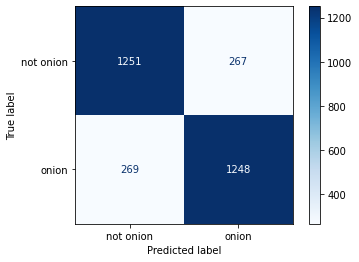

In [134]:
metrics_func(gs_nb)

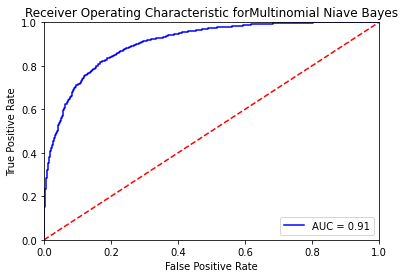

In [135]:
roc_plot(gs_nb, 'Multinomial Niave Bayes')

Plotting a "Receiver Operating Curve" allows us to visualise the how the model performs as at various classification thresholds and the trade off between True Positive rate and False Positive rate. A ROC curve also allows us to calculate the Area Under Curve that provides us with an aggregated measure of model performance across all classification thresholds.

In [136]:
#feature extraction
feature_importances_notonion = gs_nb.best_estimator_.steps[1][1].feature_log_prob_[0, :]

In [137]:
feature_importances_onion = gs_nb.best_estimator_.steps[1][1].feature_log_prob_[1, :]

In [138]:
#storing feature log_probs into a dataframe - not_onion
df_features_notonion = pd.DataFrame(data = feature_importances_notonion)
df_features_notonion = df_features_notonion.sort_values(by = 0, ascending = True).tail(10)

In [139]:
#storing feature log_probs into a dataframe - onion
df_features_onion = pd.DataFrame(data = feature_importances_onion)
df_features_onion = df_features_onion.sort_values(by = 0, ascending = True).tail(10)

In [143]:
feature_names = gs_nb.best_estimator_.steps[0][1].get_feature_names_out()
feature_names = pd.DataFrame(data = feature_names)

In [144]:
#replacing index with feature names
for index in df_features_onion.index:
    df_features_onion.rename(index = {index: feature_names.loc[index, 0]}, inplace = True)
for index in df_features_notonion.index:
    df_features_notonion.rename(index = {index: feature_names.loc[index, 0]}, inplace = True)

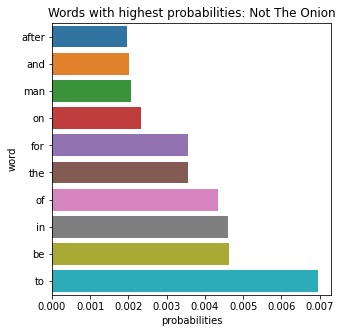

In [148]:
#plotting important features for nottheonion
plt.figure(figsize=(5, 5))
bar = sns.barplot(data = df_features_notonion, x = df_features_notonion[0].apply(lambda x: np.exp(x)), y =df_features_notonion.index)
bar.tick_params(labelsize = 10)
bar.set_xlabel('probabilities')
bar.set_ylabel('word')

bar.set_title('Words with highest probabilities: Not The Onion');

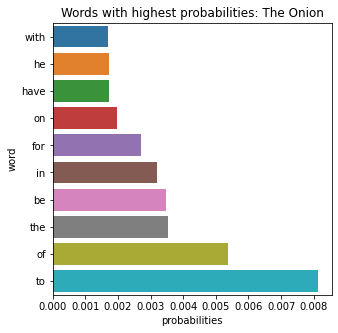

In [147]:
#plotting important features for theonion
plt.figure(figsize=(5, 5))
bar = sns.barplot(data = df_features_onion, x = df_features_onion[0].apply(lambda x: np.exp(x)), y =df_features_onion.index)
bar.tick_params(labelsize = 10)
bar.set_xlabel('probabilities')
bar.set_ylabel('word')

bar.set_title('Words with highest probabilities: The Onion');

### Log reg (hypertuning)

In [149]:
# setting parameters for log reg for tuning
lr_params = {
    'lr__penalty':['l2', 'none'],#solver lbfgs solver only accepts l2 or none
    'lr__C': [i for i in np.linspace(0.1,1,5)]
}

# combining lr params with cvec params
lr_params = lr_params|cvec_params

In [150]:
gs_lr = GridSearchCV(pipe_lr,
                     param_grid=lr_params,
                     cv=5,
                     n_jobs=-1,
                     scoring = 'f1')

In [151]:
%%time
gs_lr.fit(X_train, y_train)

/Users/hangfeng/miniforge3/envs/flow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hangfeng/miniforge3/envs/flow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hangfeng/miniforge3/envs/flow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hangfeng/miniforge3/envs/flow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hangfeng/miniforge3/envs/flow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


CPU times: user 47.7 s, sys: 13.9 s, total: 1min 1s
Wall time: 14min 17s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.3, 0.425, 0.55, 0.675, 0.8],
                         'cvec__max_features': [5000, 7000, None],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                         'cvec__stop_words': [None,
                                              ['to', 'using', 'his', 'has',
                                               'off', 'their', 'as', 'if',
                                               'they', 'did', 'it', 'on', 'in',
                                               'keep', 'not', 'how', 'many',
                                               'can', 'my', 'during', '’s',
                                               'with', 'of', 'after', 'make',
                                   

Best f1 score for model is 0.8136433276394094
test f1 score 0.82
Best params is {'cvec__max_df': 0.425, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'lr__C': 1.0, 'lr__penalty': 'l2'}
              precision    recall  f1-score   support

    NotOnion       0.82      0.82      0.82      1518
       Onion       0.82      0.82      0.82      1517

    accuracy                           0.82      3035
   macro avg       0.82      0.82      0.82      3035
weighted avg       0.82      0.82      0.82      3035



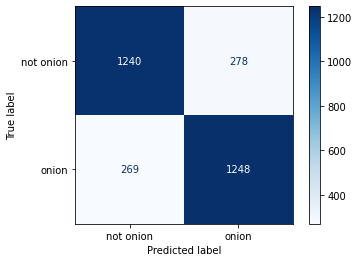

In [152]:
#getting metrics and best params
metrics_func(gs_lr)

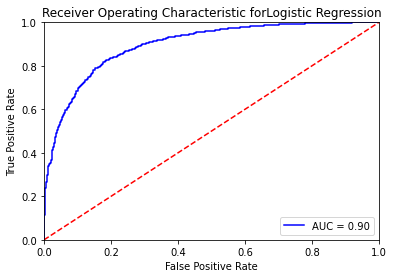

In [153]:
#plotting roc
roc_plot(gs_lr, 'Logistic Regression')

In [154]:
#obtaining regression coefficients
lr_coef = gs_lr.best_estimator_.steps[1][1].coef_

In [155]:
#saving coefs into a df
lr_coef = pd.DataFrame(data = lr_coef)


In [156]:
#as features are currently stored in a single row we will melt the dataframe into just 1 column
lr_coef =lr_coef.melt(ignore_index=True).drop(columns = ['variable'])
# next we will extract the top and bottom features into a new df
top_features_lr = lr_coef.sort_values(by = 'value', ascending = True).head(10)
top_bot_features_lr = top_features_lr.append(lr_coef.sort_values(by = 'value', ascending = True).tail(10))

In [157]:
#storing feature names
feature_names_lr = gs_lr.best_estimator_.steps[0][1].get_feature_names_out()
feature_names_lr = pd.DataFrame(data = feature_names)

In [158]:
# extracting feature names for top and bottom features
for index in top_bot_features_lr.index:
    top_bot_features_lr.rename(index = {index: feature_names_lr.loc[index, 0]}, inplace = True)

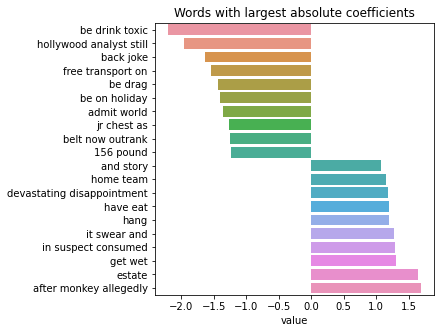

In [159]:
#plot coefficients
plt.figure(figsize=(5, 5))
bar = sns.barplot(data = top_bot_features_lr, x = top_bot_features_lr['value'], y =top_bot_features_lr.index)
bar.set_title("Words with largest absolute coefficients");

We didnt explore Trigrams in our earlier EDA, but based on the model most of the features that have large coefficients tend to be bi grams or trigrams. This would imply that the model may be placing emphasis on terms that are only used in very specific circumstances (e.g. 32 birthday fan).

On the other hand generic terms like 'australia the' or 'after eat' have lower coefficients indicating that the model is placing little focus them.

### Random forest - Hyperparameter tuning

In [165]:
# For convinience, only the best features are kept additional parameters that were part of the original hyperparam tuning commented out.
rf_params = {
    'rf__n_estimators': [300], #200
    'rf__max_depth': [None], #5, 10
    'rf__criterion': ['gini'],
    'rf__min_samples_split': [4], #2, 6
    'rf__min_samples_leaf': [1], #3, 5
    'rf__max_features': ['sqrt',None]
}

In [166]:
rf_params = rf_params|cvec_params

In [167]:
gs_rf = GridSearchCV(pipe_rf,
                     param_grid=rf_params,
                     cv=5,
                     n_jobs=-1,
                     scoring = 'f1'
                     )

In [168]:
%%time
gs_rf.fit(X_train, y_train)

CPU times: user 18.8 s, sys: 5.48 s, total: 24.2 s
Wall time: 5h 9min 38s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.3, 0.425, 0.55, 0.675, 0.8],
                         'cvec__max_features': [5000, 7000, None],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                         'cvec__stop_words': [None,
                                              ['to', 'using', 'his', 'has',
                                               'off', 'their', 'as', 'if',
                                               'they', 'did', 'it', 'on', 'in',
                                               'keep', 'not', 'how', 'many',
                                               'can', 'my', 'during', '’s',
                                               'with', 'of', 'after', 'make',
                               

Best f1 score for model is 0.7991574683775162
test f1 score 0.8
Best params is {'cvec__max_df': 0.3, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': None, 'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 4, 'rf__n_estimators': 300}
              precision    recall  f1-score   support

    NotOnion       0.84      0.67      0.75      1518
       Onion       0.73      0.87      0.80      1517

    accuracy                           0.77      3035
   macro avg       0.79      0.77      0.77      3035
weighted avg       0.79      0.77      0.77      3035



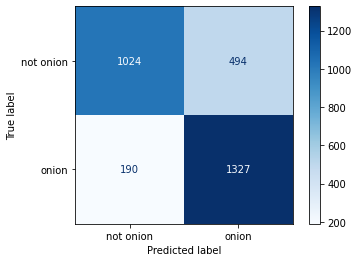

In [169]:
metrics_func(gs_rf)

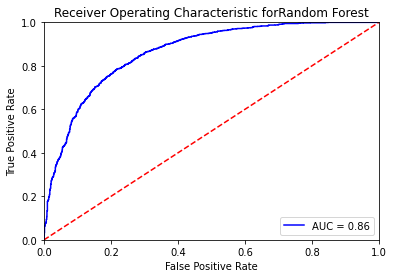

In [170]:
roc_plot(gs_rf, 'Random Forest')

In [171]:
rf_important_features = gs_rf.best_estimator_.steps[1][1].feature_importances_

In [172]:
feature_names_rf = gs_rf.best_estimator_.steps[0][1].get_feature_names_out()
feature_names_rf = pd.DataFrame(data = feature_names_rf)

In [173]:
rf_important_features = pd.DataFrame(data = rf_important_features, index = feature_names_rf.loc[:,0], columns = ['relative_importance'])

In [174]:
rf_features_top = rf_important_features.sort_values(by ='relative_importance', ascending = False).head(10)

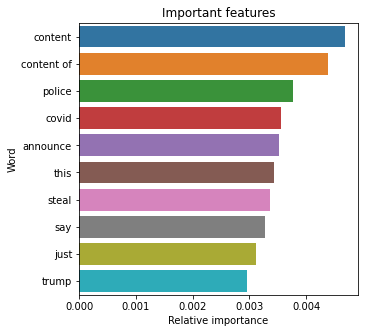

In [175]:
plt.figure(figsize=(5, 5))
plot = sns.barplot(data = rf_features_top, x = rf_features_top['relative_importance'], y =rf_features_top.index)
plot.set_xlabel('Relative importance')
plot.set_ylabel('Word')
plot.set_title('Important features');

### Model Evaluation

In [176]:
# list of models tuned
models = [gs_nb, gs_lr, gs_rf]

In [177]:
#creating a dataframe with desired model metrics
model_df = pd.DataFrame(columns=["model", "train_f1", "test_f1", "var"])

In [192]:
# look to colate scores
for model in models:
    #adding model name it df
    model_df['model'] = [f'{model.estimator.steps[1][0]}' for model in models]
    #adding training f1
    model_df['train_f1'] = [round(model.best_score_,3) for model in models]

    #add test f1
    model_df['test_f1'] = [round(model.score(X_test, y_test),3) for model in models]

    #difference between train, test score
    model_df["var"] = model_df["train_f1"] - model_df['test_f1']

In [193]:
model_df

,model,train_f1,test_f1,var
0,nb,0.819,0.823,-0.004
1,lr,0.814,0.820,-0.006
2,rf,0.799,0.795,0.004


As mentioned earlier, f1 gives us a balance between precision and recall since both FPs and FNs would result in equally severe consequences. To compare the models we have collated the train and test f1 scores in a table.

After tuning the Niave Bayes model seems to perform the best of the 3 models and compared to LR, it has a slightly smaller variance between the train and test data.

##### ROC Curve

Plotting a "Receiver Operating Curve" allows us to visualise the how the model performs as at various classification thresholds and the trade off between True Positive rate and False Positive rate. A ROC curve also allows us to calculate the Area Under Curve that provides us with an aggregated measure of model performance across all classification thresholds.

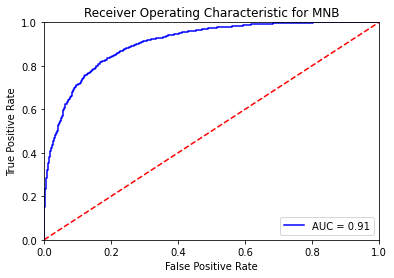

In [180]:
roc_plot(gs_nb, " MNB")

The ROC plot shows a fairly smooth curve with an AUC of 0.90 indicating that the model is a 90% chance that the model can distinguish between a post from the onion and not the onion.

The optimal classification threshold occurs at the apex of the curve at ~0.8 where we can maximise True positives while keeping FPR at a manageable level.


### Important features - MNB

In [181]:
#feature extraction
feature_importances_notonion = gs_nb.best_estimator_.steps[1][1].feature_log_prob_[0, :]
feature_importances_onion = gs_nb.best_estimator_.steps[1][1].feature_log_prob_[1, :]

In [182]:
#storing feature log_probs into a dataframe - not_onion
df_features_notonion = pd.DataFrame(data = feature_importances_notonion)
df_features_notonion = df_features_notonion.sort_values(by = 0, ascending = True)

In [183]:
#storing feature log_probs into a dataframe - onion
df_features_onion = pd.DataFrame(data = feature_importances_onion)
df_features_onion = df_features_onion.sort_values(by = 0, ascending = True)

In [184]:
#combining the features with the highest difference between P(1|feature) and P(0|feature)
df_features_combine = df_features_notonion.merge(right = df_features_onion, right_index=True, left_index = True )
df_features_combine.rename(columns = {'0_x':'prob_notonion', '0_y' :'prob_onion'}, inplace = True)
df_features_combine['prob_diff'] = np.exp(df_features_combine['prob_notonion']) - np.exp(df_features_combine['prob_onion'])

In [185]:
df_features_top = df_features_combine.sort_values(by = 'prob_diff', ascending = False)[['prob_diff']].head(10)

In [186]:
df_features_top = df_features_top.append(df_features_combine.sort_values(by = 'prob_diff', ascending = False)[['prob_diff']].tail(10))

In [187]:
df_features_top

,prob_diff
52983,0.001389
12601,0.001178
91543,0.000872
39935,0.000840
64051,0.000794
3433,0.000784
26896,0.000770
82692,0.000692
119212,0.000478
11975,0.000411


In [188]:
#getting feature names
feature_names = gs_nb.best_estimator_.steps[0][1].get_feature_names_out()
feature_names = pd.DataFrame(data = feature_names)

In [189]:
# getting feature text
for index in df_features_top.index:
    df_features_top.rename(index = {index: feature_names.loc[index, 0]}, inplace = True)

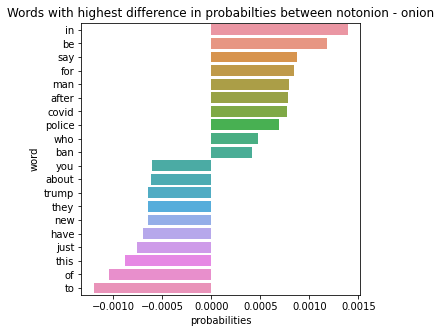

In [190]:
plt.figure(figsize=(5, 5))
bar = sns.barplot(data = df_features_top, x = df_features_top.prob_diff, y =df_features_top.index)
bar.tick_params(labelsize = 10)
bar.set_xlabel('probabilities')
bar.set_ylabel('word')
#bar.set_xticks([0.000, 0.001, 0.002, 0.003, 0.004])
bar.set_title('Words with highest difference in probabilties between notonion - onion');

Comparing difference in probabilities of features between the 2 subreddits. We can see that the difference mostly negligible for example item 1 'in', where it is only 0.1% more likely to appear in Not the Onion and the Onion. Due to the large number of features we run into issues where numbers are so small that it is hard to make meaningful comparisons which might affect interpretability of the model and identified features/words.

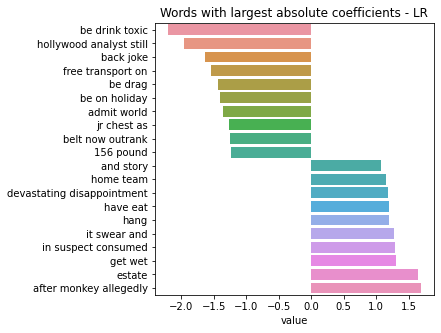

In [191]:
#plot coefficients
plt.figure(figsize=(5, 5))
bar = sns.barplot(data = top_bot_features_lr, x = top_bot_features_lr['value'], y =top_bot_features_lr.index)
bar.set_title("Words with largest absolute coefficients - LR");

Compared to regression coefficients produced by the LR model that are more easily interpreted. As previously discussed we can see that the lr models places emphasis on unique bi and trigrams like 'Autonomous weapon or' (e.g. drones) that would rarely appear in typical news stories, while terms like 'speeding' which appears fairly commonly in news articles on road accidents is associated with not the onion.

## Conclusion

Overall the MNB, LR and RF models have generally comparable with f1 scores of ~ 0.8.

Ultimately, Multinomial Naive Bayes was chosen as the model was able to achieve the highest f1 score of 0.82. Plotting the ROC curve the model boasts an AUC of 0.9 or a 90% chance that it can distinguish between a post from the Onion and not the Onion.

Considering that the model is intended to be used as a way to distinguish between real and fake news, the stakes are relatively high since a single misclassified article/headline could have severe and far reaching consequences.

With a 20% error rate it would be risky to use the model to classify between real and fake news as it currently is and margin of error should be lowered further before using the model to classify between real and fake news.

In addition, as the headlines for fictional articles was taken from a single source, the model could be overfit to the the editorial choices (like content, word selection) specific to the Onion which could negatively impact models ability to process fake news from other sources.

## Recommendations

Further improvements to lower the margin of error is recommended.

First, additional samples of both real and fake news headlines from a variety of sources should be collected and used to develop the model further. A good place to start would be subreddits like 'worldnews' and 'news' that focus on news from around the world and 'America'.

Secondly, the model is built based on data collected before 01 Jan 2022, as such the relevancy of the corpus used to train the model will become an issue as time passes and new global developments (such as covid) dominate future news cycles or with the introduction of new terminology (such as the shift from the term sars-cov2 to the use of covid 19).

Finally, the Multinomial Naive Bayes is not ideal when interpretability is required and when the corpus is expected to grow. For MNB feature log probs become problematic when there is a large number of unique features that result in very small probabilities for a given class, this problem is likely to grow as additional data points with new terms are introduced.

In contrast, switching to a model like logistic regression, where feature regression coefficients are easier to interpret and access different regularization algorithms that can mitigate the impact of increasing the language corpus can be mitigated, would be worth considering in the future.